In [1]:
%matplotlib inline
import glob
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np
from lmfit import Parameter, Parameters, Minimizer

import lmfit

from itertools import product

from mixcoatl.sourcegrid import coordinate_distances, fit_error, BaseGrid

In [2]:
infiles = glob.glob('/nfs/slac/g/ki/ki19/lsst/snyder18/LSST/Data/BOT/6861D_long/catalogs/*.cat')
infile = infiles[0]

In [11]:
## Input
y0_guess = 2000.
x0_guess = 2000.
ncols = nrows = 49
distortions = None

## Module Code
src = fits.getdata(infile)

## Get source positions
srcY = src['base_SdssShape_X']
srcX = src['base_SdssShape_Y']

## Curate data here (remove bad shapes, fluxes, etc.)
srcW = np.sqrt(np.square(src['base_SdssShape_XX']) + np.square(src['base_SdssShape_YY']))
mask = (srcW > 4.)

srcY = src['base_SdssShape_X'][mask]
srcX = src['base_SdssShape_Y'][mask]

## Construct mask
nsources = srcY.shape[0]
indices, distances = coordinate_distances(srcY, srcX, srcY, srcX)
nn_indices = indices[:, 1:5]
nn_distances = distances[:, 1:5]
med_dist = np.median(nn_distances)

dist1_array = np.full(nsources, np.nan)
dist2_array = np.full(nsources, np.nan)
theta_array = np.full(nsources, np.nan)

for i in range(nsources):

    yc = srcY[i]
    xc = srcX[i]

    for j in range(4):

        nn_dist = nn_distances[i, j]
        if np.abs(nn_dist - med_dist) > 10.: continue
        y_nn = srcY[nn_indices[i, j]]
        x_nn = srcX[nn_indices[i, j]]

        if x_nn > xc:
            if y_nn > yc:
                dist1_array[i] = nn_dist
                theta_array[i] = np.arctan((y_nn-yc)/(x_nn-xc))
            else:
                dist2_array[i] = nn_dist

theta = np.nanmedian(theta_array)
if theta >= np.pi/4.:
    theta = theta - (np.pi/2.)
    xstep = np.nanmedian(dist2_array)
    ystep = np.nanmedian(dist1_array)
else:
    xstep = np.nanmedian(dist1_array)
    ystep = np.nanmedian(dist2_array)
    
print(theta)

## Perform Fit
params = Parameters()
params.add('ystep', value=ystep, vary=False)
params.add('xstep', value=xstep, vary=False)
params.add('theta', value=theta, vary=False)
params.add('y0', value=y0_guess, min=y0_guess-ystep, max=y0_guess+ystep, vary=True, brute_step=ystep/4.)
params.add('x0', value=x0_guess, min=x0_guess-xstep, max=x0_guess+xstep, vary=True, brute_step=xstep/4.)

print(params.valuesdict)

minner = Minimizer(fit_error, params, fcn_args=(srcY, srcX, ncols, nrows, distortions))
result = minner.minimize(method='brute', params=params)

params = result.params
params['theta'].set(vary=True)

minner = Minimizer(fit_error, params, fcn_args=(srcY, srcX, ncols, nrows, distortions))
result = minner.minimize(params=params)

0.054245293894455315
<bound method Parameters.valuesdict of Parameters([('ystep', <Parameter 'ystep', value=65.33259599633124 (fixed), bounds=[-inf:inf]>), ('xstep', <Parameter 'xstep', value=65.33906795286308 (fixed), bounds=[-inf:inf]>), ('theta', <Parameter 'theta', value=0.054245293894455315 (fixed), bounds=[-inf:inf]>), ('y0', <Parameter 'y0', value=2000.0, bounds=[1934.6674040036687:2065.3325959963313], brute_step=16.33314899908281>), ('x0', <Parameter 'x0', value=2000.0, bounds=[1934.6609320471368:2065.339067952863], brute_step=16.33476698821577>)])>


6223.846702016542
OrderedDict([('ystep', 65.33259599633124), ('xstep', 65.33906795286308), ('theta', 0.05418132157550086), ('y0', 2051.4816415659266), ('x0', 2000.0)])


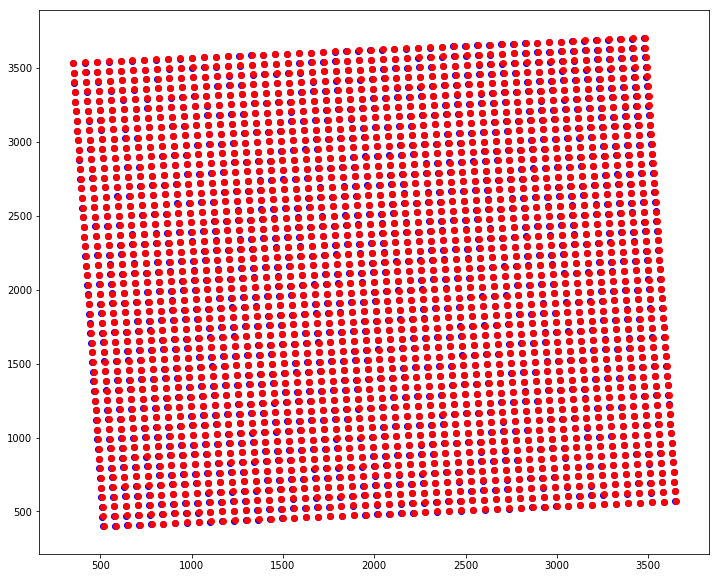

In [12]:
print(np.sum(result.residual))
parvals = result.params.valuesdict()
print(parvals)

ystep = parvals['ystep']
xstep = parvals['xstep']
theta = parvals['theta']
y0 = parvals['y0']
x0 = parvals['x0']

## Create grid model and construct x/y coordinate arrays
grid = BaseGrid(ystep, xstep, theta, y0, x0, ncols, nrows)    
gY, gX = grid.make_ideal_grid()

fig, ax = plt.subplots(1, 1, figsize=(12, 10))

ax.scatter(srcX, srcY, color='blue')
ax.scatter(gX, gY, color='red')

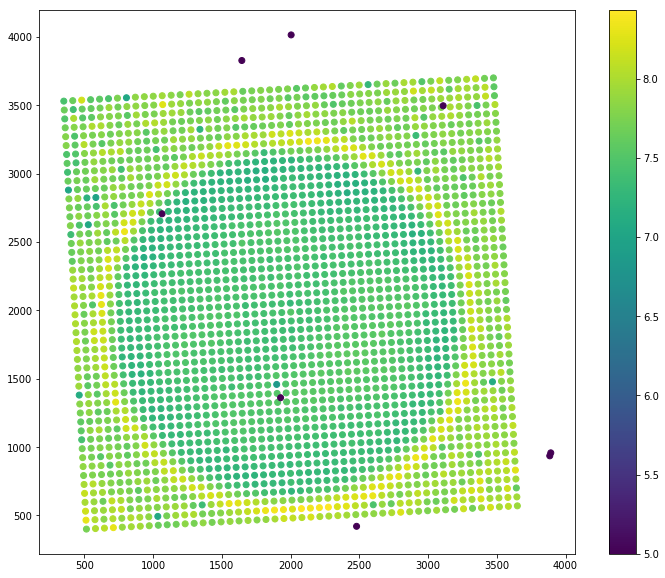

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

srcY = src['base_SdssShape_X']
srcX = src['base_SdssShape_Y']
z = np.sqrt(np.square(src['base_SdssShape_XX']) + np.square(src['base_SdssShape_YY']))

im = ax.scatter(srcX, srcY, c=z, vmin=5)
fig.colorbar(im)